# Transfer Learning with DenseNet169

Due to the limited memory and optimal image size used for DenseNet169, I'll be initially using much fewer images. 

Since the data has been cleaned before, there won't be much preprocessing besides rescaling the keypoints to match the image sizes used for DensetNet169. But I'd still like to visualize the distribution and correlation of the keypoints, in case it might be a little different with a smaller number of images.

This notebook is structured as follows:
* [1. Data Wrangling](#1)
    * [1.1 Loading Keypoints Data](#1.1)
    * [1.2 Images Data](#1.2)
    * [1.3 Preprocessing](#1.3)
* [2. EDA](#2)
    * [2.1 Distribution of the Keypoints](#2.1)
    * [2.2 Heatmap of Keypoints](#2.2)
    * [2.3 Correlation Map of Keypoints](#2.3)
* [3. General Helper Functions](#3)
* [4. Modeling](#4)
    * [4.1 Splitting Data](#4.1)
    * [4.2 Building and Training Model](#4.2)
    * [4.3 Testing and Evaluating Model](#4.3)
* [5. Explainability with GradCAM](#5)

In [1]:
#Ignore warnings for a cleaner display
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import keras
import tensorflow as tf
import PIL

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image

In [3]:
#Install dependencies
!pip install tf_explain --quiet

In [4]:
from tf_explain.core.grad_cam import GradCAM

# 1. Data Wrangling <a name='1'></a>

## 1.1 Loading Keypoints Dataset <a name='1.1'></a>

**The facial keypoints dataset:** the same dataset will be used. It contains the x- and y-coordinates of the facial images' five keypoints (left eye, right eye, nose, left side of the mouth, and right side of the mouth).

The difference this time is that the new image dimensions will be 224 x 224.

In [5]:
#Define paths to keypoints datasets
keypts_data_path = "../input/celeba-dataset/list_landmarks_align_celeba.csv"
images_data_path = "../input/celeba-dataset/img_align_celeba/img_align_celeba"

#Select only 2k images first
img_data_size = 2000

#Original image dimensions
x_og = 178
y_og = 218
image_size_ratio = x_og / y_og

# New image dimensions
x_ = 224
y_ = 224

# Image Sizes
original_image_size = (x_og, y_og)
new_image_size = (x_,y_)

# The image size that will be used in the training process
image_size_training = new_image_size

In [6]:
keypts_og = pd.read_csv(keypts_data_path)[:img_data_size]
keypts_og.sample(5)

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
413,000414.jpg,70,111,107,111,89,135,73,152,105,153
632,000633.jpg,68,112,109,112,90,133,66,152,111,150
1056,001057.jpg,71,111,106,110,86,137,73,153,103,154
1015,001016.jpg,70,109,105,112,108,131,73,152,107,155
502,000503.jpg,69,111,108,111,89,136,74,152,102,152


In [7]:
keypts_og.describe()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.00000
mean,69.318000,111.214500,107.688500,111.179000,87.685000,135.04050,71.261000,152.052500,105.577500,152.17300
std,1.669811,1.122105,1.662784,1.141758,6.674283,4.40063,3.193271,1.745069,3.255348,1.70544
min,62.000000,105.000000,96.000000,101.000000,65.000000,112.00000,61.000000,145.000000,92.000000,144.00000
25%,68.000000,111.000000,107.000000,111.000000,84.000000,133.00000,69.000000,151.000000,103.000000,151.00000
50%,69.000000,111.000000,108.000000,111.000000,88.000000,135.00000,72.000000,152.000000,105.000000,152.00000
75%,70.000000,112.000000,109.000000,112.000000,91.000000,138.00000,73.000000,153.000000,108.000000,153.00000
max,82.000000,118.000000,116.000000,117.000000,120.000000,146.00000,83.000000,164.000000,115.000000,164.00000


In [8]:
keypts_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      2000 non-null   object
 1   lefteye_x     2000 non-null   int64 
 2   lefteye_y     2000 non-null   int64 
 3   righteye_x    2000 non-null   int64 
 4   righteye_y    2000 non-null   int64 
 5   nose_x        2000 non-null   int64 
 6   nose_y        2000 non-null   int64 
 7   leftmouth_x   2000 non-null   int64 
 8   leftmouth_y   2000 non-null   int64 
 9   rightmouth_x  2000 non-null   int64 
 10  rightmouth_y  2000 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 172.0+ KB


In [9]:
keypts_og.shape

(2000, 11)

## 1.2 Images Data <a name='1.2'></a>
Loading the images data involves converting it to arrays so it may be used it in training the model.

In [10]:
images = []

for idx in range(keypts_og.shape[0]):
    #Retrieve path
    path = "{}/{}".format(str(images_data_path), str(keypts_og.iloc[idx].image_id))
    
    #Reading images
    image = PIL.Image.open(path).resize(image_size_training)
    image_array = np.asarray(image) / 255
    
    #Append images
    images.append(image_array)

In [11]:
#Convert to array
images = np.array(images)

images.shape

(2000, 224, 224, 3)

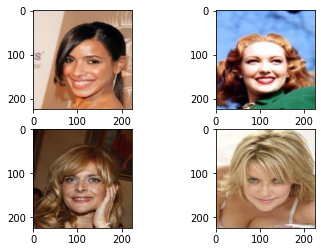

In [12]:
#Plotting sample images
idx1, idx2, idx3, idx4 = np.random.randint(0, img_data_size, size=4)

fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(images[idx1])
axs[1,0].imshow(images[idx2])
axs[1,1].imshow(images[idx3])
axs[0,1].imshow(images[idx4])
plt.show()

## 1.3 Pre-Processing<a name='1.3'></a>
Because DenseNet169 was trained on 224 x 224 images, the keypoints coordinates need to rescaled to that scale as well.

In [13]:
#Create a function to resize keypts
def resize_df(df_og, x=x_og, y=None):
    """This function helps resize the dataframes with any independent coordinates 
    so that they correspond correctly with the dataset.
    
    ...
    Paremeters
    ----------
    df : dataframe
        The dataframe containing any coordinates related to the x-y values that need to be rescaled
    x : int
        The x-value to resize the image
    y : int, optional
        The y-value to resize the image (default is automatically maintaining the original x-y size ratio)
    
    Returns
    --------
    dataframe
        A dataframe containing the rescaled coordinates
    
    """
    
    if y is None:
        y = int(image_size_ratio * x)
    
    x_, y_ = x, y
    image_size_training = (x_, y_)
    
    df = df_og.copy()
    x_old, y_old = x_og, y_og
    x_new, y_new = image_size_training

    #Get ratio of new to old for rescaling
    x_ratio = x_new / x_old
    y_ratio = y_new / y_old

    keypts_x = ['lefteye_x', 'righteye_x', 'nose_x', 'leftmouth_x', 'rightmouth_x']
    keypts_y = ['lefteye_y', 'righteye_y', 'nose_y', 'leftmouth_y', 'rightmouth_y']

    #Rescale the keypoints
    df[keypts_x] = (df_og[keypts_x] * x_ratio).astype('int')
    df[keypts_y] = (df_og[keypts_y] * y_ratio).astype('int')
        
    return df

In [14]:
#Rescale the keypoints for a 224x224 image
keypts = resize_df(keypts_og, x=224, y=224)

In [15]:
#Compare with original keypoints to see if rescaled
keypts_og.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


In [16]:
#Check rescaled keypoints
keypts.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,86,112,133,116,96,145,91,156,135,158
1,000002.jpg,86,113,134,115,101,138,88,155,135,157
2,000003.jpg,95,115,130,108,135,131,93,160,123,162
3,000004.jpg,90,116,135,110,127,141,89,159,127,155
4,000005.jpg,83,117,140,115,108,122,89,151,130,154


In [17]:
#Look at general description of rescaled keypoints
keypts.describe()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,86.745000,114.195000,134.953500,114.16100,109.880000,138.042500,89.195500,156.052000,132.348500,156.172000
std,2.152043,1.195696,2.125935,1.21112,8.452001,4.405837,3.993777,1.747233,4.080977,1.710228
min,78.000000,107.000000,120.000000,103.00000,81.000000,115.000000,76.000000,148.000000,115.000000,147.000000
25%,85.000000,114.000000,134.000000,114.00000,105.000000,136.000000,86.000000,155.000000,129.000000,155.000000
50%,86.000000,114.000000,135.000000,114.00000,110.000000,138.000000,90.000000,156.000000,132.000000,156.000000
75%,88.000000,115.000000,137.000000,115.00000,114.000000,141.000000,91.000000,157.000000,135.000000,157.000000
max,103.000000,121.000000,145.000000,120.00000,151.000000,150.000000,104.000000,168.000000,144.000000,168.000000


# 2. EDA <a name='2'></a>
Just to confirm the distribution of the smaller number of images isn't unusual, I'll be plotting:
1. Distribution of the keypoints coordinates
2. Visualization of the facial attributes

## 2.1 Distribution of the Keypoints Coordinates <a name='2.1'></a>
Since the images dataset is already cropped into nice images with the face roughly centered, I still expect the coordinates to be roughly concentrated around particular areas despite the smaller number of images. For example, the right eye coordinates would be expected to mostly be in the right upper quadrant. If this is not the case, there could be transformed or different types of facial images in the dataset.

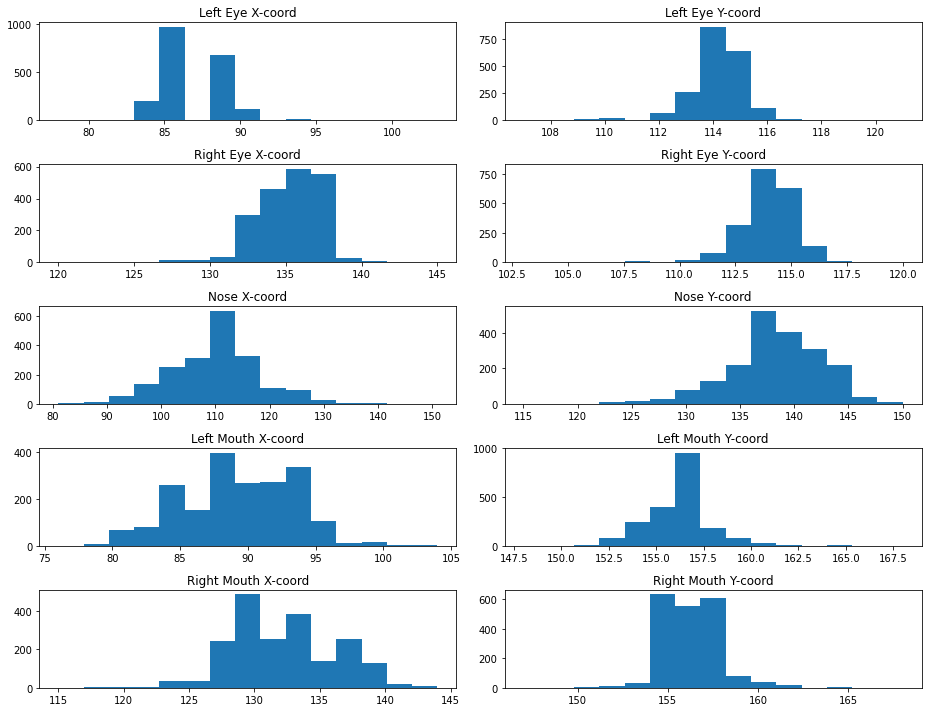

In [18]:
#Plotting distribution of the keypoints' coordinates
fig, axs = plt.subplots(5, 2, figsize=(13,10))

#Left eye
axs[0,0].hist(keypts.lefteye_x, bins=15)
axs[0,0].set_title('Left Eye X-coord')
axs[0,1].hist(keypts.lefteye_y, bins=15)
axs[0,1].set_title('Left Eye Y-coord')

#Right eye
axs[1,0].hist(keypts.righteye_x, bins=15)
axs[1,0].set_title('Right Eye X-coord')
axs[1,1].hist(keypts.righteye_y, bins=15)
axs[1,1].set_title('Right Eye Y-coord')

#Nose
axs[2,0].hist(keypts.nose_x, bins=15)
axs[2,0].set_title('Nose X-coord')
axs[2,1].hist(keypts.nose_y, bins=15)
axs[2,1].set_title('Nose Y-coord')

#Left mouth
axs[3,0].hist(keypts.leftmouth_x, bins=15)
axs[3,0].set_title('Left Mouth X-coord')
axs[3,1].hist(keypts.leftmouth_y, bins=15)
axs[3,1].set_title('Left Mouth Y-coord')

#Right mouth
axs[4,0].hist(keypts.rightmouth_x, bins=15)
axs[4,0].set_title('Right Mouth X-coord')
axs[4,1].hist(keypts.rightmouth_y, bins=15)
axs[4,1].set_title('Right Mouth Y-coord')

plt.tight_layout()
plt.show()

## 2.2 Heatmap of Keypoints<a name='2.2'></a>
To add more visual context of where these coordinates lie:

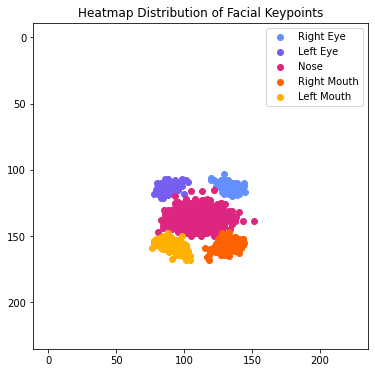

In [19]:
#Plot a sample box of with a heatmap of where the coordinates are
fig, ax = plt.subplots(figsize=(6,6))

rect = patches.Rectangle((0, 0), 224, -224, linewidth=4, facecolor='none')
ax.add_patch(rect)

#Add scatter plots of the coordinates with colorblind friendly colors
ax.scatter(keypts.righteye_x, -keypts.righteye_y, color='#648FFF', label='Right Eye')
ax.scatter(keypts.lefteye_x, -keypts.lefteye_y, color='#785EF0', label='Left Eye')
ax.scatter(keypts.nose_x, -keypts.nose_y, color='#DC267F', label='Nose')
ax.scatter(keypts.rightmouth_x, -keypts.rightmouth_y, color='#FE6100', label='Right Mouth')
ax.scatter(keypts.leftmouth_x, -keypts.leftmouth_y, color='#FFB000', label='Left Mouth')

#Add legend for the colors
leg = ax.legend()
#Set legend opacity colors to opaque (1)
for lh in leg.legendHandles:
    lh.set_alpha(1)

#Display positive y-ticks
ax.get_yaxis().set_ticklabels([250, 200, 150, 100, 50, 0])
    
plt.title('Heatmap Distribution of Facial Keypoints')
plt.show()

## 2.3 Correlation of the Keypoint Coordinates<a name='2.3'></a>

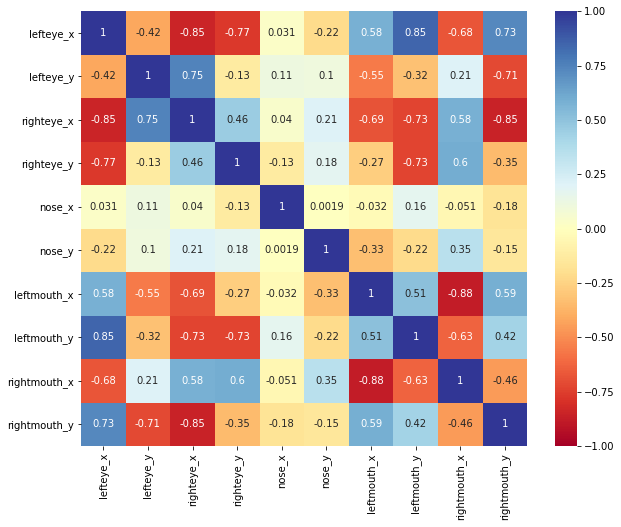

In [20]:
#Correlation map
corrmap = keypts.iloc[:,1:].corr()

#Plot the correlation map
plt.subplots(figsize=(10,8))
sns.heatmap(corrmap, cmap='RdYlBu', vmin=-1, vmax=1, annot=True)
plt.show()

## 3. Helper Functions <a name='3'></a>

In [21]:
#Read image based on index
def imread_index(index, size=image_size_training, path=images_data_path):
    """This function helps read images based on the its index by converting it to an array.
    """
    path = "{}/{}".format(str(path), str(keypts_og.iloc[index].image_id))
    
    #read the image
    image = PIL.Image.open(path).resize(size)
    image_array = np.asarray(image)
    
    return image_array

In [22]:
#Get a list of all key points of the face
def img_keypts_list(index, df=keypts_og):
    """ This function returns a list of all the key points of the face image so 
    it's easier to plot
    """
    points_list = [df.iloc[index].lefteye_x, df.iloc[index].lefteye_y,
                  df.iloc[index].righteye_x, df.iloc[index].righteye_y,
                  df.iloc[index].nose_x, df.iloc[index].nose_y,
                  df.iloc[index].leftmouth_x, df.iloc[index].leftmouth_y,
                  df.iloc[index].rightmouth_x, df.iloc[index].rightmouth_y]
    
    return points_list

In [23]:
#Plot image with green bounding box and keypoints
def plot_face_bbox(index, df=keypts_og, size=original_image_size):
    """ This function plots the face image with its keypoints and bounding box
    """
    img = imread_index(index, size)
    points_list = img_keypts_list(index, df)
    
    #Plotting the image
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    #Plot the face points
    ax.plot(points_list[::2], points_list[1::2], 'bo-')
    
    #Plot bounding box
    width = abs(points_list[0] - points_list[8] - 60) #obtain width from left eye x to right mouth x
    height = abs(points_list[1] - points_list[9] - 75)#obtain width from left eye y to right mouth y
    rect = patches.Rectangle((points_list[0]-30, points_list[1]-40), width, height, linewidth=4, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    
    #Remove axis
    plt.axis('off')
    plt.show()

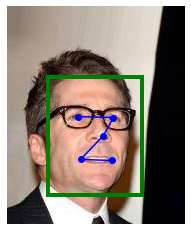

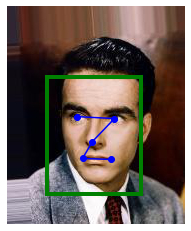

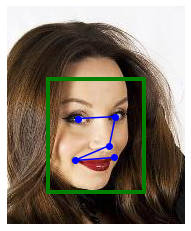

In [24]:
#test
idx1, idx2, idx3 = np.random.randint(0, img_data_size, size=3)

#Test plotting sample images
plot_face_bbox(idx1)
plot_face_bbox(idx2)
plot_face_bbox(idx3)

# 4. Modeling <a name='4'></a>
Now we can begin the modeling section.

## 4.1 Splitting data into training and test datasets <a name='4.1'></a>
Since there is much fewer images, instead of using 20% for the test set, I'll be using 150 out of the 1,000.

In [25]:
test_size = int(img_data_size * 0.2)

# training data
train_labels = keypts[:img_data_size - test_size]
train_images = images[:img_data_size - test_size]


# test data (20%)
test_labels = keypts[img_data_size - test_size + 1:]
test_images = images[img_data_size - test_size + 1:]

### Train and Validation Sets

In [26]:
#Dropping image_id column
y = train_labels.drop(['image_id'], axis = 1) 
X = train_images

# check
y.head(3)

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,86,112,133,116,96,145,91,156,135,158
1,86,113,134,115,101,138,88,155,135,157
2,95,115,130,108,135,131,93,160,123,162


In [27]:
#Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state = 42)

#Check the ratio
X_val.shape[0]/X_train.shape[0]

0.25

## 4.2 Building and Training the Model <a name='4.2'></a>
Using transfer learning, the pre-trained DenseNet169 with the imagenet weights can be utilized.

In [28]:
IMG_SHAPE = image_size_training + (3,)

In [29]:
from keras.applications import DenseNet169

dn_model = DenseNet169(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

51879936/51877672 [==============================] - 1s 0us/step


In [30]:
dn_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [31]:
#Freeze base model layers
dn_model.training = False

In [32]:
from keras.layers import Flatten, Dense, MaxPooling2D, Dropout, Conv2D
from keras.models import Model

#Construct the head model to be placed on top of the DenseNet169 model
headModel = dn_model.output
headModel = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(7,7,1664))(headModel)
headModel = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Flatten()(headModel)

headModel = Dense(64, activation='relu')(headModel)
headModel = Dropout(0.2)(headModel)

headModel = Dense(32, activation='relu')(headModel)
headModel = Dropout(0.2)(headModel)

headModel = Dense(16, activation='relu')(headModel)
headModel = Dropout(0.2)(headModel)

headModel = Dense(10, activation='relu')(headModel)

In [33]:
#Combine the two models
new_model = Model(inputs=dn_model.input, outputs=headModel)

In [34]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [35]:
#Compile the model
new_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

### Training the Model
Due to limited memory and the architecture of DenseNet169, I need to decrease the `batch_size` during training but will increase the number of epochs to make up for it.

In [36]:
#Fit model 
training_process = new_model.fit(X_train, y_train, epochs=400, validation_data=(X_val, y_val), batch_size=50, shuffle=True)

Epoch 1/400
26/26 [==============================] - 44s 626ms/step - loss: 11298.4594 - mse: 11298.4594 - val_loss: 7987.0273 - val_mse: 7987.0273
Epoch 2/400
26/26 [==============================] - 10s 371ms/step - loss: 7576.9183 - mse: 7576.9183 - val_loss: 5139.2412 - val_mse: 5139.2412
Epoch 3/400
26/26 [==============================] - 9s 366ms/step - loss: 6100.8868 - mse: 6100.8868 - val_loss: 2747.1150 - val_mse: 2747.1150
Epoch 4/400
26/26 [==============================] - 10s 369ms/step - loss: 4158.6935 - mse: 4158.6934 - val_loss: 4714.3955 - val_mse: 4714.3955
Epoch 5/400
26/26 [==============================] - 10s 369ms/step - loss: 3302.0103 - mse: 3302.0103 - val_loss: 3327.0750 - val_mse: 3327.0750
Epoch 6/400
26/26 [==============================] - 10s 370ms/step - loss: 2644.1697 - mse: 2644.1697 - val_loss: 2430.6594 - val_mse: 2430.6594
Epoch 7/400
26/26 [==============================] - 9s 364ms/step - loss: 2092.6689 - mse: 2092.6689 - val_loss: 797.9296 

In [37]:
#Load trained model from previous commits to save time
#model_path = '../input/model/densenet169'
#model = keras.models.load_model(model_path)

In [38]:
#Check the loss and accuracy from loaded model to make sure it's same as last time
#loss, mse = model.evaluate(test_images, test_labels.drop(['image_id'], axis=1))

### Saving model and data for future reference:

In [39]:
#Saving the model as SavedModel format
new_model.save('densenet169')

In [40]:
from IPython.display import FileLink, FileLinks
import os

In [41]:
os.chdir(r'/kaggle/working')
os.listdir()

['__notebook__.ipynb', 'densenet169']

In [42]:
#Download model
FileLinks(r'densenet169')

densenet169/
  saved_model.pb
densenet169/variables/
  variables.data-00000-of-00001
  variables.index

## 4.3 Testing and Evaluating the Model<a name='4.3'></a>

In [43]:
# function to plot the image with green box around the faces
def plot_test_img(index, model, pred_or_actual = 'pred', pointsColor='ro-', boxcolor='g'):
    img = tf.keras.preprocessing.image.load_img("{}/000{}.jpg".format(images_data_path, index),target_size=(y_og,x_og,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    test_image = img/255
    model = model
    
    #Obtain predictions for key points of face
    if pred_or_actual == 'pred':
        img = tf.keras.preprocessing.image.load_img("{}/000{}.jpg".format(images_data_path, index),target_size=(y_,x_,3))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img/255
        
        points_list = model.predict(img.reshape(1,y_,x_,3)).astype('int')[0]
        
        #convert key pts values to original size
        x_ratio = 1.05 * (original_image_size[0] / image_size_training[0])
        y_ratio = 1.085 * (original_image_size[1] / image_size_training[1])
        
        points_list[0] = int(points_list[0] * x_ratio)
        points_list[2] = int(points_list[2] * x_ratio)
        points_list[4] = int(points_list[4] * x_ratio)
        points_list[6] = int(points_list[6] * x_ratio)
        points_list[8] = int(points_list[8] * x_ratio)
    
        points_list[1] = int(points_list[1] * y_ratio)
        points_list[3] = int(points_list[3] * y_ratio)
        points_list[5] = int(points_list[5] * y_ratio)
        points_list[7] = int(points_list[7] * y_ratio)
        points_list[9] = int(points_list[9] * y_ratio)
        
        title = 'Predicted'
        
    elif pred_or_actual == 'actual':      
        points_list = img_keypts_list(index)
        pointsColor = 'bo-'
        title = 'Actual'
    
    # face points
    le_x, le_y, re_x, re_y = points_list[0], points_list[1], points_list[2], points_list[3]
    n_x, n_y = points_list[4], points_list[5]
    lm_x, lm_y, rm_x, rm_y = points_list[6], points_list[7], points_list[8], points_list[9]

    # Create figure and axes
    fig, ax = plt.subplots()
    # plot the image
    ax.imshow(test_image)
    # plot the points on the face
    ax.plot([le_x,re_x,n_x,lm_x,rm_x], [le_y,re_y,n_y,lm_y,rm_y], pointsColor)
    ax.set_title(title)
    
    # plot the box around the face
    width = abs(le_x-rm_x-60)
    height = abs(le_y-rm_y-75)
    rect = patches.Rectangle((le_x-30, le_y-40), width, height, linewidth=4, edgecolor=boxcolor, facecolor='none')
    ax.add_patch(rect);
    return points_list

[69, 111, 107, 112, 84, 136, 64, 152, 114, 153]

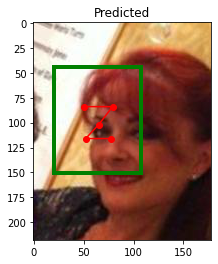

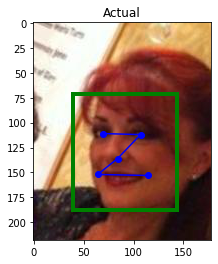

In [44]:
index = 410
plot_test_img(index, new_model, pred_or_actual = 'pred')
plot_test_img(index, new_model, pred_or_actual='actual')

### Evaluation of the Model:

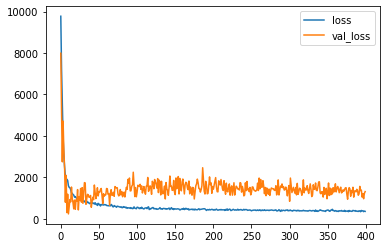

In [45]:
# losses of both training and validation sets
loss = training_process.history['loss']
val_loss = training_process.history['val_loss']

# plot both losses
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss']);

Evaluate the model MSE for each coordinate:

In [46]:
#Evaluation function to calculate MSE for each coordinate
def eval_model(labels, predictions, as_df=False):
    """Calculate the MSE for each of the ten coordinates, plus an average of all the MSEs, with the option to output as a DataFrame or a list."""
    mse_list = []
    
    #Calculate each MSE and add to list
    for i in np.arange(10):
        if(type(labels)==pd.DataFrame):
            mse_list.append(mean_squared_error(labels.iloc[:,i], [coord[i] for coord in predictions]))
        else:
            mse_list.append(mean_squared_error([label[i] for label in labels], [coord[i] for coord in predictions]))
        
    #Calculate average MSE
    mse_list.append(np.mean(mse_list))
    
    #Optional output as dataframe
    if(as_df):
        cols = keypts_og.columns[1:].tolist()
        cols.append('average')
        
        df = pd.DataFrame(columns=cols)
        df.loc['MSE'] = mse_list
        
        return df
    #Otherwise output as list
    else:
        return mse_list

In [47]:
test_lbs = test_labels.drop(['image_id'], axis=1)

evaluate = eval_model(test_lbs, new_model.predict(test_images), as_df=True)
evaluate

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y,average
MSE,606.102189,1074.123476,1522.636998,1075.399572,1062.829816,1589.266041,663.228334,2056.222515,1459.134658,2054.620098,1316.35637


## Saving model information for model comparison
This information will be saved in a more accessible .csv file for comparison between models.

In [48]:
#Load the model csv
model_data_path = '../input/model-data/model_data.csv'
exp = pd.read_csv(model_data_path, index_col=0)
exp

,loss,val_loss,epoch,batch,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,...,scaled_lefteye_y,scaled_righteye_x,scaled_righteye_y,scaled_nose_x,scaled_nose_y,scaled_leftmouth_x,scaled_leftmouth_y,scaled_rightmouth_x,scaled_rightmouth_y,scaled_avg
Custom,"[488.2683410644531, 178.78807067871094, 128.86...","[432.4057922363281, 359.76934814453125, 364.08...",300.0,200.0,0.550627,0.129648,0.659737,0.121735,2.054469,1.611473,...,1.086083,1.679185,1.052759,3.622839,3.151933,4.333488,1.542611,2.933389,1.498164,NaN
Benchmark,NaN,NaN,NaN,NaN,0.607453,0.116987,0.596380,0.120998,9.215325,1.576290,...,1.031692,1.596521,1.049569,7.672811,3.117335,4.464671,1.198461,3.050495,1.151519,2.683297


In [49]:
def add_exp(df, name, train_name, epoch, batch, mse_data):
    """Add all relevant model information into one .csv file for easy access and comparison."""
    #Add all training loss
    df.loc[name,'loss'] = np.ndarray(shape=(2,1))
    df.loc[name,'loss'].clear()
    df.loc[name,'loss'].extend(train_name.history['loss'])
    
    #Add all validation loss
    df.loc[name,'val_loss'] = np.ndarray(shape=(2,1))
    df.loc[name,'val_loss'].clear()
    df.loc[name,'val_loss'].extend(train_name.history['val_loss'])
    
    #Add epoch and batch_size used during training
    df.loc[name, 'epoch'] = epoch
    df.loc[name, 'batch'] = batch
      
    #Add metrics 
    cols = mse_data.columns[:-1].tolist()
    scaled_columns = []
    
    for col in cols:
        scaled_col = 'scaled_'+col
        scaled_columns.append(scaled_col)
        
        #Add MSE
        df.loc[name, col] = mse_data.loc['MSE', col]
        
        #Convert MSE to RMSE then divide by the coordinate average, multiplied by 100
        df.loc[name, scaled_col] = np.sqrt(df.loc[name, col]) / keypts[col].mean() * 100
    
    #Add average metrics
    df.loc[name, 'average'] = mse_data.loc['MSE', 'average']
    
    avg = np.mean(df.loc[name, scaled_columns])
    df.loc[name, 'scaled_avg'] = avg
    
    return df

In [50]:
model_metrics = add_exp(exp, 'DenseNet169', training_process, 400, 50, evaluate)
model_metrics

,loss,val_loss,epoch,batch,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,...,scaled_lefteye_y,scaled_righteye_x,scaled_righteye_y,scaled_nose_x,scaled_nose_y,scaled_leftmouth_x,scaled_leftmouth_y,scaled_rightmouth_x,scaled_rightmouth_y,scaled_avg
Custom,"[488.2683410644531, 178.78807067871094, 128.86...","[432.4057922363281, 359.76934814453125, 364.08...",300.0,200.0,0.550627,0.129648,0.659737,0.121735,2.054469,1.611473,...,1.086083,1.679185,1.052759,3.622839,3.151933,4.333488,1.542611,2.933389,1.498164,NaN
Benchmark,NaN,NaN,NaN,NaN,0.607453,0.116987,0.596380,0.120998,9.215325,1.576290,...,1.031692,1.596521,1.049569,7.672811,3.117335,4.464671,1.198461,3.050495,1.151519,2.683297
DenseNet169,"[9773.1923828125, 7211.0439453125, 5543.328613...","[7987.02734375, 5139.2412109375, 2747.11499023...",400.0,50.0,606.102189,1074.123476,1522.636998,1075.399572,1062.829816,1589.266041,...,28.699876,28.914390,28.725471,29.669704,28.879222,28.872779,29.058000,28.862149,29.024356,28.908700


In [51]:
model_metrics.loc['DenseNet169']

loss                   [9773.1923828125, 7211.0439453125, 5543.328613...
val_loss               [7987.02734375, 5139.2412109375, 2747.11499023...
epoch                                                              400.0
batch                                                               50.0
lefteye_x                                                     606.102189
lefteye_y                                                    1074.123476
righteye_x                                                   1522.636998
righteye_y                                                   1075.399572
nose_x                                                       1062.829816
nose_y                                                       1589.266041
leftmouth_x                                                   663.228334
leftmouth_y                                                  2056.222515
rightmouth_x                                                 1459.134658
rightmouth_y                                       

In [52]:
#Save dataframe
model_metrics.to_csv('model_data.csv')

In [53]:
#Download csv
FileLink(r'model_data.csv')

/kaggle/working/model_data.csv

# 5. Explainability of the Model <a name='5'></a>

Instead of blindly trusting the 'black box,' I'm going to be delving further into what is going on to evaluate any explainability to the model. It is important to note that explainability does not directly mean interpretability. Somewhat knowing what the model doesn't necessarily mean we'll be able to extract the meaning out of what it's doing. 

It'll be interesting to see if the pre-trained portion causes the model to be vastly different from the original.

In [54]:
#Take a random image from the dataset
IDX = 540

path = "{}/{}".format(str(images_data_path), str(keypts_og.iloc[IDX].image_id))
im = PIL.Image.open(path).resize(image_size_training)
im_array = np.asarray(im)

im = im_array.reshape(-1, y_, x_, 3)
im.shape

(1, 224, 224, 3)

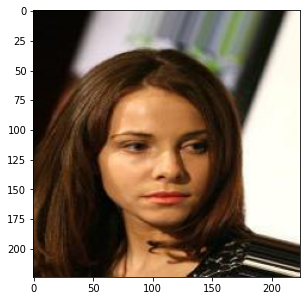

In [55]:
fig = plt.figure(figsize=(6,6*image_size_ratio))
plt.imshow(im_array/255)
plt.show()

In [56]:
#Check the loss and accuracy of the sample image
#obtain the actual value and reshape it as a tensor
actual = np.asarray(keypts.iloc[IDX].drop(['image_id'])).transpose().reshape(-1,10).astype(np.float32)

eval_model(actual, new_model.predict(im), as_df=True)

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y,average
MSE,2219.415527,4197.431641,5817.382324,4087.708252,4439.868652,5761.842285,2515.071533,7845.094727,5527.747559,7647.499512,5005.905762


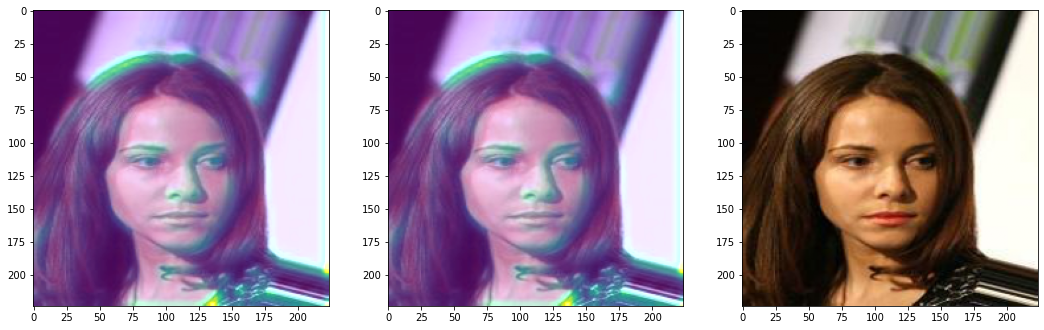

In [57]:
#Visualize GradCAM output from 1st conv layer for left-eye y-coord and nose x-coord
explainer = GradCAM()

grid1 = explainer.explain((im, None), new_model, 1, 'conv2_block4_1_conv')
grid2 = explainer.explain((im, None), new_model, 4, 'conv2_block4_1_conv')

#Plot the visualizations
fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(im_array / 255.)
ax1.imshow(grid1, alpha=1)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(im_array / 255.)
ax2.imshow(grid2, alpha=1)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(im_array / 255.)

The model is looking at the edges and outlines of the shapes, which makes sense since it's looking at one of its early layers. Going deeper into the CNN model, however, gives more model explainability.

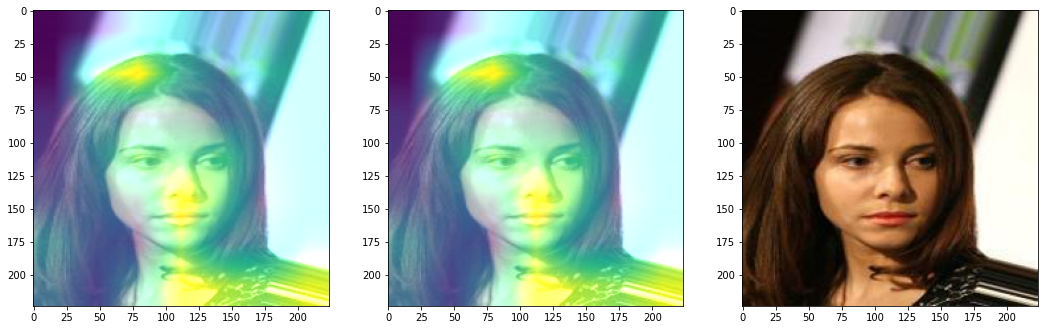

In [58]:
#Visualize GradCAM output from 4th conv layer
grid1 = explainer.explain((im, None), new_model, 1, 'conv5_block22_1_conv')
grid2 = explainer.explain((im, None), new_model, 4, 'conv5_block22_1_conv')

#Plot the visualizations
fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(im_array / 255.)
ax1.imshow(grid1, alpha=1)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(im_array / 255.)
ax2.imshow(grid2, alpha=1)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(im_array / 255.)

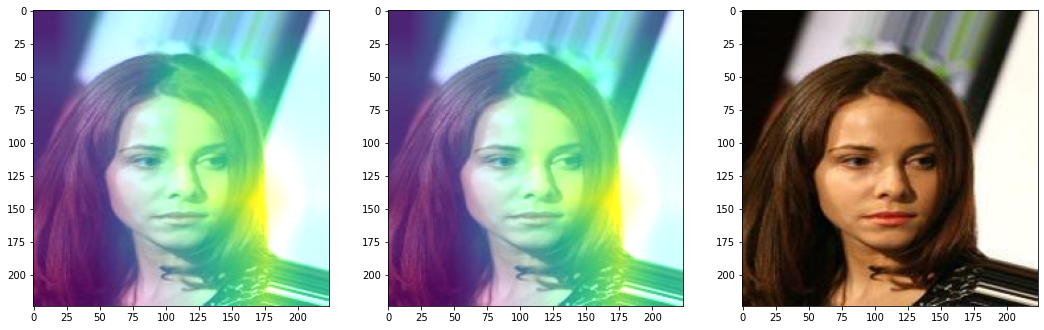

In [59]:
#Visualize GradCAM output from last conv layer
grid1 = explainer.explain((im, None), new_model, 1, 'conv2d_1')
grid2 = explainer.explain((im, None), new_model, 4, 'conv2d_1')

#Plot the visualizations
fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(im_array / 255.)
ax1.imshow(grid1, alpha=1)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(im_array / 255.)
ax2.imshow(grid2, alpha=1)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(im_array / 255.)